# **An exploration of causal graphs**

**Premise:** We're data scientists at an outdoor supply vendor that has a lot of historical data but differing opinions on how to improve sales.

Your boss learned that almost a quarter of tent and camping supply searches involve TV shows, ads, or travel sites, so she wants to license camping equipment from brands like Patagonia and REI. Your sales lead thinks the company should focus on getting more product to market, sooner. And another colleague asks ChaptGPT/Bard, which suggests adding more types of product.  

We want to use data to understand the drivers of outdoor supply sales and where to best focus efforts to increase sales. Quantifying and testing the strengths of different interventions will be key in making our recommendation.

We'll be using the PyWhy ecosystem, which is available open source: https://github.com/py-why. In particular:

1.   DoWhy: https://github.com/py-why/dowhy
2.   EconML: https://github.com/py-why/EconML
3.   (Future) PyWhyLLM: https://github.com/py-why/pywhy-llm

After setting up the environment, we'll walk through **2 examples**:

1. Simple example
2. More complex tree-based example

Each example will have **4 main steps**:

1.   Modeling the causal graph (includes data creation in this example)
2.   Identifying the formulas to be used to calculate causal effects
1.   Estimating the causal effects of different approaches
2.   Validating (trying to refute) our results.

# **Environment setup**

In [ ]:
!pip install dowhy
!pip install matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.4/174.4 kB 7.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import dowhy
from dowhy import CausalModel
import dowhy.datasets
import matplotlib.pyplot as plt
import seaborn as sns

# **Simple Example**

## **Step 1 - Create and Model a hypothetical supply chain dataset:**

Let's assume a simple supply chain where the number of camping supplies affects the production rate, and the production rate affects the sales.

In [ ]:
np.random.seed(42)
num_data_points = 1000
camping_supplier = np.random.randint(1, 10, size=num_data_points)
raw_materials = np.random.randint(1, 100, size=num_data_points)
production_rate = camping_supplier * 10 + np.random.normal(0, 5, size=num_data_points)
sales = production_rate * 5 + np.random.normal(0, 10, size=num_data_points)

df = pd.DataFrame({
    'camping_supplier': costume_supplier,
    'raw_materials': raw_materials,
    'production_rate': production_rate,
    'sales': sales
})

In [ ]:
df

,camping_supplier,raw_materials,production_rate,sales
0,7,88,69.055517,353.692866
1,4,87,42.765366,207.650466
2,8,59,79.831567,421.034336
3,5,72,45.248259,207.296565
4,7,54,65.647137,322.598683
...,...,...,...,...
995,8,36,82.922863,426.437844
996,1,75,10.019015,54.912914
997,9,51,81.868403,402.383402
998,7,15,67.350311,350.765846


Define the causal model:
Using the data, we can define a causal model. We'll assume that the number of camping supplies affects the production rate, and the production rate affects sales.

In [ ]:
causal_graph = """
digraph {
    camping_supplier -> production_rate;
    raw_materials -> production_rate;
    production_rate -> sales;
}
"""
model = CausalModel(
    data=df,
    treatment='camping_supplier',
    outcome='sales',
    graph=causal_graph
)


ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


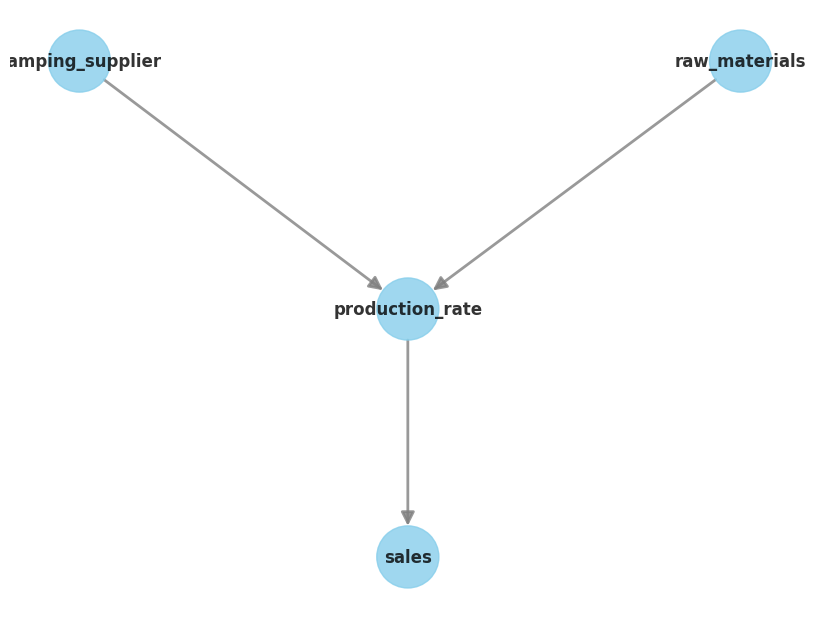

In [ ]:
# Visualize the graph
model.view_model(layout="dot")
plt.show()

## **Step 2 - Identify the causal expression measures:**

In [ ]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                   
──────────────────(E[sales])
d[campingₛᵤₚₚₗᵢₑᵣ]          
Estimand assumption 1, Unconfoundedness: If U→{camping_supplier} and U→sales then P(sales|camping_supplier,,U) = P(sales|camping_supplier,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡        d                        d                           ⎤
E⎢─────────────────(sales)⋅──────────────────([productionᵣₐₜₑ])⎥
 ⎣d[productionᵣₐₜₑ]        d[campingₛᵤₚₚₗᵢₑᵣ]                  ⎦
Estimand assumption 1, Full-mediation: production_rate intercepts (blocks) all directed paths from camping_supplier to s,a,l,e,s.
Estimand assumption 2, First-stage-unconfoundedness: If U→{camping_supplier} and U→{production_rate} then P(production_rate|camping_supplier,U) = P(production_rate|camping_supplier)
Estimand assumption 3, Second-

### Explanation on ATE, estimands, backdoor, and frontdoor methods

**EstimandType.NONPARAMETRIC_ATE:** This suggests that the Average Treatment Effect (ATE) being estimated is non-parametric, which means the estimation does not assume any specific functional form.

  1.   **Estimand: 1 (backdoor)**

      * Estimand name: "backdoor" method.

      * Estimand expression: This is the derivative of the expected sales with respect to camping suppliers, essentially capturing the effect of a change in camping supplies on sales.

      * Unconfoundedness Assumption: This is an important assumption that must hold for backdoor adjustments. It assumes that, conditional on some variables (not seen in this output), there are no unobserved confounders (DoWhy actually assumes all variables are confounders which maybe we can discuss) between camping suppliers and sales.

  2.   **Estimand: 2 (iv)**

      * Estimand name: "iv" stands for Instrumental Variables. This method is used when there are unobserved confounders, and one needs an instrument (a variable that affects the treatment but not the outcome directly).

      * The output suggests that no such instrumental variable was found in the dataset or the model.

  3.   **Estimand: 3 (frontdoor)**

      * Estimand name: "frontdoor" method.

      * Estimand expression: This involves a two-stage process using an intermediary variable, in this case, "production_rate." The expression captures the effect of a change in camping suppliers on production rate and then the effect of a change in production rate on sales.

      * Full-mediation Assumption: Assumes that "production_rate" is the only pathway through which "camping suppliers" affects "sales." In other words, any effect of camping suppliers on sales must pass through production_rate.

* First-stage-unconfoundedness: Similar to the unconfoundedness assumption for the backdoor method, but now applied to the relationship between camping suppliers and production_rate.

* Second-stage-unconfoundedness: Again, similar to the unconfoundedness assumption but applied to the relationship between production_rate and sales, while controlling for camping suppliers.

To summarize, we show three different potential methods to measure the effect of "camping suppliers" on "sales." The backdoor method looks at the direct relationship while controlling for confounders. The IV method would use instrumental variables if any were available. The frontdoor method, on the other hand, investigates the relationship through an intermediary variable, "production_rate," and requires multiple assumptions about the relationships between these variables and potential confounders.

## **Step 3 - Estimate the causal effect:**

We can use different methods to estimate the causal effect. Here, we'll use a simple linear regression.

In [ ]:
estimate = model.estimate_effect(identified_estimand,
                                method_name="backdoor.linear_regression",
                                test_significance=True)
print(estimate)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                   
──────────────────(E[sales])
d[campingₛᵤₚₚₗᵢₑᵣ]          
Estimand assumption 1, Unconfoundedness: If U→{camping_supplier} and U→sales then P(sales|camping_supplier,,U) = P(sales|camping_supplier,)

## Realized estimand
b: sales~camping_supplier+camping_supplier*raw_materials
Target units: 

## Estimate
Mean value: 49.995645787358306
p-value: [0.]
### Conditional Estimates
__categorical__raw_materials
(0.999, 20.0]    50.090282
(20.0, 40.0]     50.041914
(40.0, 60.0]     49.995121
(60.0, 80.0]     49.946434
(80.0, 99.0]     49.898981
dtype: float64


### Explanation on Estimands ... update section

This output provides information about the causal estimate between "camping suppliers" and "sales." The output can be divided into three main sections:

1. **Identified Estimand**:
    - **EstimandType.NONPARAMETRIC_ATE**: This indicates that the Average Treatment Effect (ATE) being estimated is non-parametric, which means the estimation does not assume any specific functional form.
    
    - **Estimand: 1 (backdoor)**:
        - **Estimand name**: Refers to the "backdoor" method, which tries to find a set of variables that, once controlled for, can open a non-confounded path from the treatment (camping suppliers) to the outcome (sales).
        
        - **Estimand expression**: This is a mathematical representation of the causal effect, essentially calculating the effect of a change in "camping suppliers" on the expected value of "sales".
        
        - **Unconfoundedness Assumption**: An important assumption for the backdoor criterion. It assumes that there are no unobserved confounders between "camping suppliers" and "sales" when certain conditions are met, as implied by the probability expression.

2. **Realized Estimand**:
    - This section describes how the causal effect was modeled.
    - **b: sales~camping suppliers**: This implies a simple linear regression where "sales" is the dependent variable and "camping suppliers" is the independent variable (i.e., \( sales = \beta_0 + \beta_1 \times camping suppliers + \epsilon \), where \( \beta_1 \) would be the realized estimand).
    - **Target units**: "ate" stands for Average Treatment Effect. This means the objective is to estimate the average effect of "camping suppliers" on "sales" across all units (or entities) in the dataset.

3. **Estimate**:
    - **Mean value**: This is the estimated causal effect. A value of approximately 49.9023 implies that for a unit increase in the number of camping suppliers, there's an associated increase in sales by about 49.9023 units, on average.
    
    - **p-value**: This is a measure of the statistical significance of the observed effect. A p-value of "[0.]" means that the observed effect is extremely statistically significant (typically a threshold like 0.05 is used, where values below it indicate statistical significance).

In conclusion, based on this output, it appears that there is a statistically significant relationship between "camping suppliers" and "sales". Increasing the number of camping supplies by one unit is associated with an average increase in sales of approximately 49.9023 units.

Production here is considered a mediator.

## **Step 4 - Refute the results:**

DoWhy also provides methods to test the robustness of the causal effect estimates. This refutation test is way to challenge or "refute" the validity of a causal effect estimate.

In causal inference, after obtaining an estimate, it's a good practice to validate the robustness of this estimate using various refutation methods.

In [ ]:
refutation = model.refute_estimate(identified_estimand, estimate,
                                   method_name="random_common_cause")
print(refutation)


Refute: Add a random common cause
Estimated effect:49.995645787358306
New effect:49.995947465743996
p value:0.98



### Explanation for refuting results

Adding randomness did not meaningfully alter our estimate, which increases our confidence that the estimated effect is not a result of confounding or other modeling issues.

- **Refute: Add a random common cause**: This refutation method tests the validity of the causal effect by adding a random common cause to the model and then recalculating the effect. The idea is that adding a random variable as a common cause should not significantly change the estimated causal effect if the original effect is robust.

- **Estimated effect**: This is the original causal effect estimate which suggests that a unit increase in the treatment variable is associated with an approximate 49.9023 units increase in the outcome.

- **New effect**: After adding the random common cause to the model, the causal effect estimate slightly changes to approximately 49.9020.

- **p value**: The p-value of 0.96 is extremely high, suggesting that the difference between the original effect and the new effect is not statistically significant.

**Interpretation:**

The fact that the "New effect" is very close to the "Estimated effect" and the associated p-value is high suggests that the original causal effect is robust to the addition of a random common cause. In other words, adding randomness did not meaningfully alter our estimate, increasing our confidence that the original estimated effect is reliable and not merely a result of confounding or other model-specific issues.

Other refutations:

Placebo Treatment: What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)

Dummy Outcome: What happens to the estimated causal effect when we replace the true outcome variable with an independent random variable? (Hint: The effect should go to zero)

Simulated Outcome: What happens to the estimated causal effect when we replace the dataset with a simulated dataset based on a known data-generating process closest to the given dataset? (Hint: It should match the effect parameter from the data-generating process)

Add Unobserved Common Causes: How sensitive is the effect estimate when we add an additional common cause (confounder) to the dataset that is correlated with the treatment and the outcome? (Hint: It should not be too sensitive)

Data Subsets Validation: Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)

Bootstrap Validation: Does the estimated effect change significantly when we replace the given dataset with bootstrapped samples from the same dataset? (Hint: It should not)

https://pypi.org/project/dowhy/#iv-refute-the-obtained-estimate

# **Complex Example**

## **Step 1 - Create and Model a Complex Graph:**

Let's add more variables to our supply chain example:

1.   Camping Supplies Variety: The different types of camping supplies available.
2.   Pricing: The price at which each camping gear is sold to customers at.

In [ ]:
np.random.seed(42)
num_data_points = 1000

# Variables
camping_supplier = np.random.randint(1, 10, size=num_data_points)
raw_materials = np.random.randint(1, 100, size=num_data_points)
gear_variety = np.random.uniform(0.5, 1.5, size=num_data_points)
pricing = np.random.randint(1000, 5000, size=num_data_points)

# Relationships
production_rate = camping_supplier * 10 + raw_materials * 0.5 + np.random.normal(0, 5, size=num_data_points)
sales = (production_rate * 5 + pricing * 0.1) * gear_variety + np.random.normal(0, 10, size=num_data_points)

df = pd.DataFrame({
    'camping_supplier': camping_supplier,
    'raw_materials': raw_materials,
    'gear_variety': gear_variety,
    'pricing': pricing,
    'production_rate': production_rate,
    'sales': sales
})

In [ ]:
df

,camping_supplier,raw_materials,gear_variety,pricing,production_rate,sales
0,7,88,1.434436,2833,113.863550,1231.832764
1,4,87,0.851623,3367,82.163719,653.539304
2,8,59,0.601421,1125,111.440851,400.075683
3,5,72,0.985872,1276,86.193635,547.782946
4,7,54,0.756777,2999,90.311453,570.255692
...,...,...,...,...,...,...
995,8,36,0.519116,4474,96.693355,481.247259
996,1,75,0.976843,1127,45.852804,330.499751
997,9,51,1.187722,2845,112.929237,1034.864048
998,7,15,1.222707,4548,78.862579,1058.848715


In [ ]:
causal_graph = """
digraph {
    camping_supplier -> production_rate;
    raw_materials -> production_rate;
    raw_materials -> pricing;
    production_rate -> sales;
    pricing -> sales;
    gear_variety -> sales;
}
"""
model = CausalModel(
    data=df,
    treatment='camping_supplier',
    outcome='sales',
    graph=causal_graph
)


ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


As the business owner, where should I invest in which scenario?

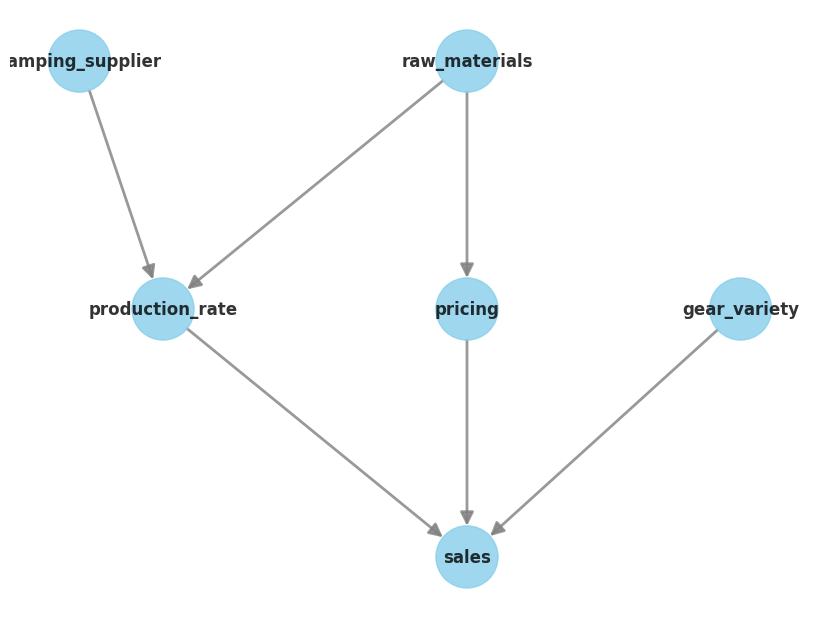

In [ ]:
# Visualize the graph
model.view_model(layout="dot")
plt.show()

## **Step 2 - Identify the Causal Expression:**

In [ ]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                   
──────────────────(E[sales])
d[campingₛᵤₚₚₗᵢₑᵣ]          
Estimand assumption 1, Unconfoundedness: If U→{camping_supplier} and U→sales then P(sales|camping_supplier,,U) = P(sales|camping_supplier,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [ ]:
estimate = model.estimate_effect(identified_estimand,
                                method_name="backdoor.linear_regression",
                                test_significance=True)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                   
──────────────────(E[sales])
d[campingₛᵤₚₚₗᵢₑᵣ]          
Estimand assumption 1, Unconfoundedness: If U→{camping_supplier} and U→sales then P(sales|camping_supplier,,U) = P(sales|camping_supplier,)

## Realized estimand
b: sales~camping_supplier+camping_supplier*raw_materials+camping_supplier*pricing+camping_supplier*gear_variety
Target units: 

## Estimate
Mean value: 47.960953281568834
p-value: [5.47015353e-259]
### Conditional Estimates
__categorical__raw_materials  __categorical__pricing  __categorical__gear_variety
(0.999, 20.0]                 (1006.999, 1882.8]      (0.501, 0.701]                 -39.653133
                                                      (0.701, 0.913]                 -22.181461
                                                      (0.913, 1.102]                  11.813116


In [ ]:
refutation = model.refute_estimate(identified_estimand, estimate,
                                   method_name="random_common_cause")
print(refutation)

Refute: Add a random common cause
Estimated effect:47.960953281568834
New effect:47.96457981930582
p value:0.94



## **Step 3 (Alternative) - Estimate Causal Expressions using a CausalForestDML:**

We know the treatment effect function is nonlinear, so let's use CausalForestDML to fit another model. This allows us to use a fully nonparametric estimate of the treatment effect, and evaluate our model more robustly.

In [ ]:
!pip install dowhy econml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 22.3 MB/s eta 0:00:00


In [ ]:
import econml

In [ ]:
from econml.dml import CausalForestDML
from sklearn.ensemble import GradientBoostingRegressor

# Define treatment, outcome, and covariates
T = df['camping_supplier'].values
Y = df['sales'].values
X = df[['pricing', 'raw_materials', 'gear_variety', 'production_rate']].values

# Initialize the causal forest model
model = CausalForestDML(model_y=GradientBoostingRegressor(),
                        model_t=GradientBoostingRegressor(),
                        discrete_treatment=False)

# Fit the model
model.fit(Y, T, X=X)

# Estimate the causal effect
effect = model.effect(X)

# Add the estimated effect to the dataset
df['estimated_effect'] = effect

/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/usr/local/lib/python3.10/dist-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

In [ ]:
df

,camping_supplier,raw_materials,gear_variety,pricing,production_rate,sales,estimated_effect
0,7,88,1.434436,2833,113.863550,1231.832764,-6.593610
1,4,87,0.851623,3367,82.163719,653.539304,4.469911
2,8,59,0.601421,1125,111.440851,400.075683,5.392357
3,5,72,0.985872,1276,86.193635,547.782946,7.693907
4,7,54,0.756777,2999,90.311453,570.255692,4.356552
...,...,...,...,...,...,...,...
995,8,36,0.519116,4474,96.693355,481.247259,2.441114
996,1,75,0.976843,1127,45.852804,330.499751,-1.599074
997,9,51,1.187722,2845,112.929237,1034.864048,-4.765675
998,7,15,1.222707,4548,78.862579,1058.848715,0.068342


In [ ]:
# Get the underlying trees from the causal forest
trees = model.model_final_.estimators_

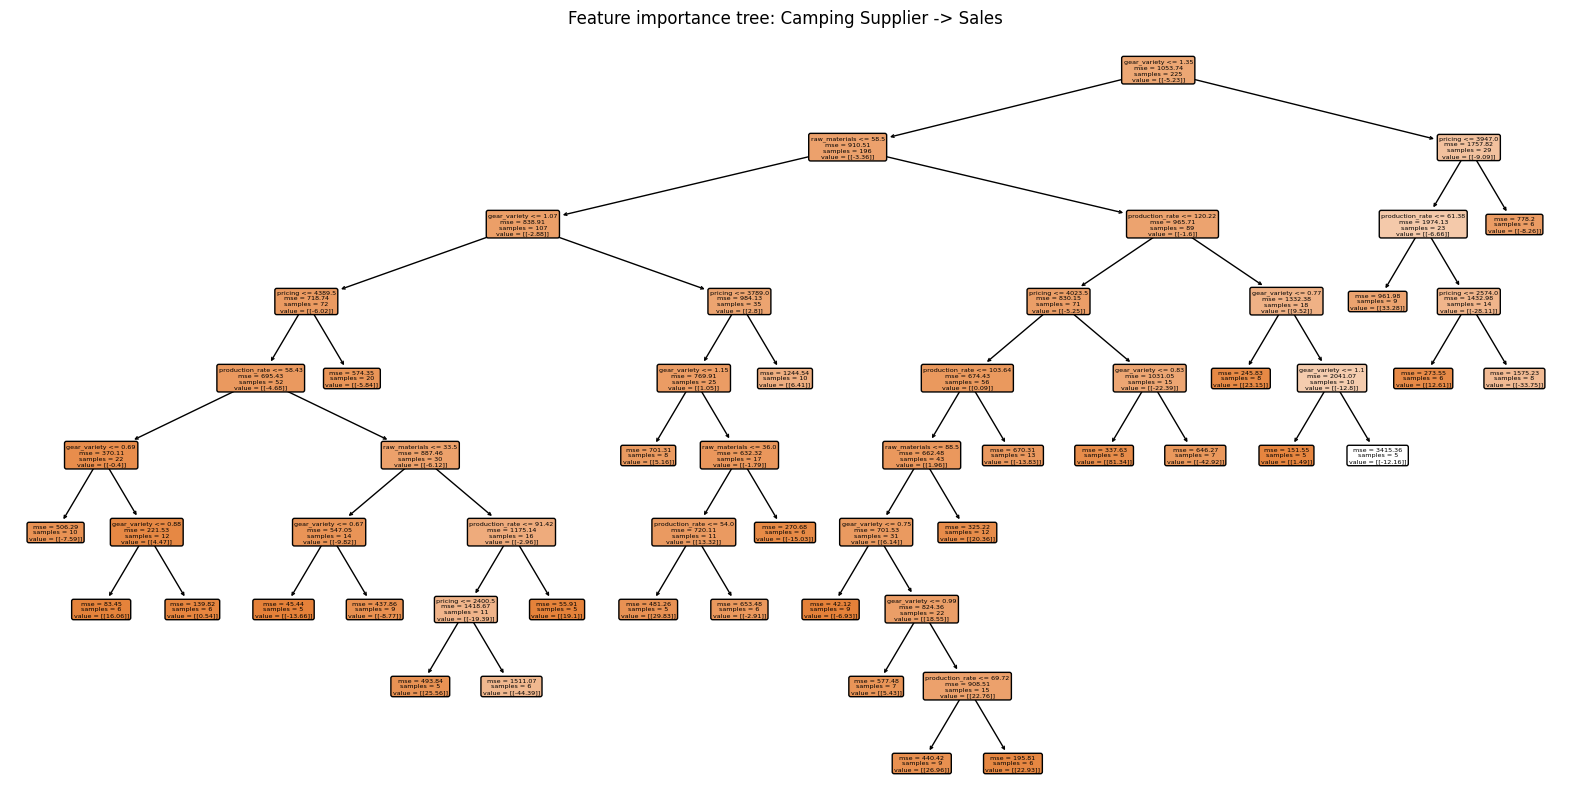

In [ ]:
from sklearn.tree import plot_tree

# Plot a few trees for visualization
n_trees_to_plot = 3

for i in range(min(n_trees_to_plot, len(trees))):
    plt.figure(figsize=(20, 10))
    plot_tree(trees[i][0], filled=True, feature_names=['pricing', 'raw_materials', 'gear_variety', 'production_rate'], rounded=True, precision=2)
    plt.title(f"Feature importance tree: Camping Supplier -> Sales")
    plt.show()


# **Conclusion**

Which interventions on treatments that impact sales the most? (What changes have the most impact to sales?)

What if we changed where we focus our resources this year?

1.   Model:
* Camping Supplier (branded/not)
* Gear variety
* Production rate
* Material (quality)
* Pricing
* Sales (output)

2.   Identify: Use ATE (ave. treatment effect)  to measure the effect of these variables on sales. SME input → Updates

3.   Estimate: Find the causal strength of interventions on sales using linear regression. Then use EconML for Causal Forest

4.   Refute: Test robustness of findings by adding randomness, checking new vs estimated effect and the p values. Look at the feature importance to understand split of trees in Causal Forest method.


Present Results!
